In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

# Get head-pose data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [15]:
path

PosixPath('/home/quantran/.fastai/data/biwi_head_pose')

In [8]:
path.ls()

[PosixPath('/home/quantran/.fastai/data/biwi_head_pose/22'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/02'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/01.obj'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/io_sample.cpp'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/09.obj'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/18.obj'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/14'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/03'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/22.obj'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/21'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/readme.txt'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/05'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/07'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/06.obj'),
 PosixPath('/home/quantran/.fastai/data/biwi_head_pose/15.obj'),
 PosixPath('/home/quantran/.fastai/data/bi

## Depth sensing camera calibration

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [5]:
fname = '09/frame_00667_rgb.jpg'
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

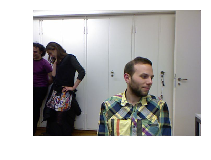

In [6]:
img = open_image(path/fname)
img.show()

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [10]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

In [14]:
get_ip(img, ctr)

torch.Size([480, 640])

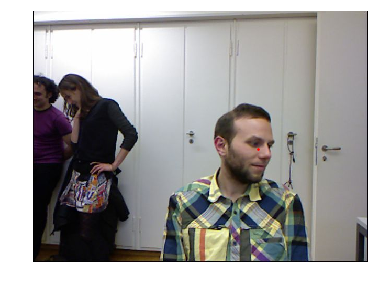

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

# Create dataset

In [16]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

In [33]:
x,y=data.train_ds[0]

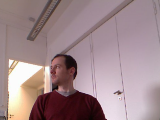

In [36]:
x

In [37]:
y

ImagePoints (120, 160)

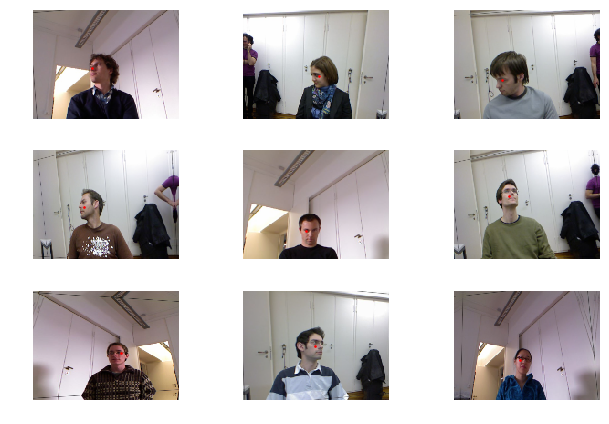

In [17]:
data.show_batch(3, figsize=(9,6))

# Train

In [18]:
learn = create_cnn(data, models.resnet34)
# learn.loss_func = MSELossFlat()

In [49]:
learn.loss_func

FlattenedLoss of MSELoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


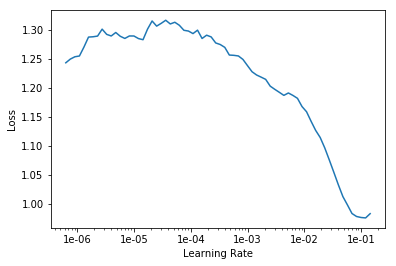

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 2e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.047482,0.006200
2,0.017073,0.004671
3,0.008318,0.004882
4,0.005147,0.000351
5,0.003787,0.000698


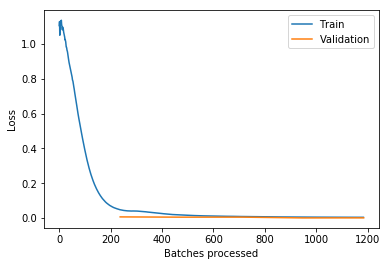

In [21]:
learn.recorder.plot_losses()

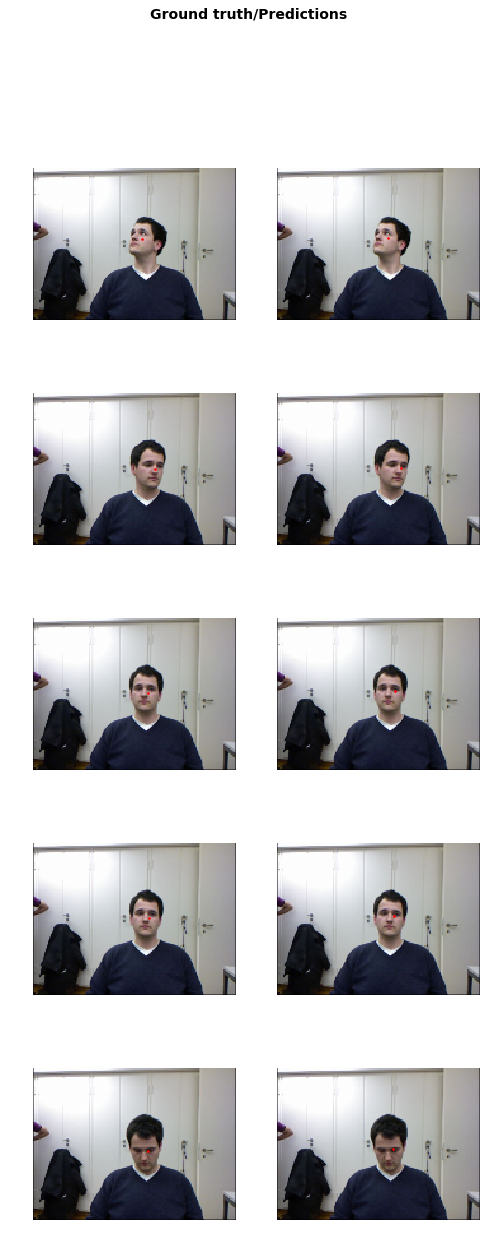

In [22]:
learn.show_results()

# Check augmentation

In [23]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

In [24]:
idxs=np.random.permutation(len(data.train_ds))[:10]

In [40]:
train_ds = data.train_ds

In [29]:
temp_tfms = get_transforms()

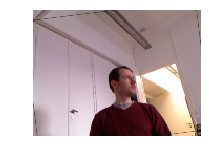

In [42]:
train_ds[0][0].show()

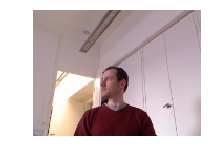

In [43]:
train_ds[0][0].show()

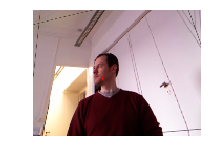

In [46]:
train_ds[0][0].show(y=train_ds[0][1])

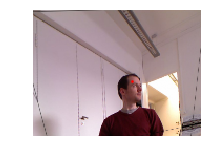

In [47]:
train_ds[0][0].show(y=train_ds[0][1])

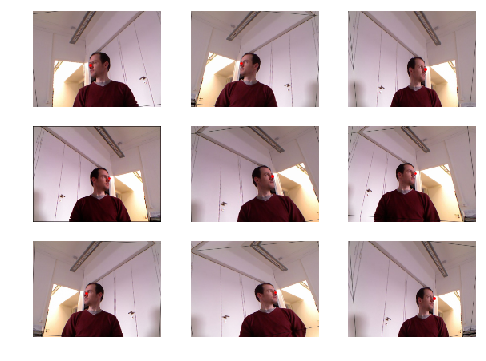

In [48]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))
#plot_multi is just a wrapper for _plot